Target: Reduce parameters still further <br>

Results: <br>
Parameters: 8,680 (<10K) <br> <br>
Best Training Accuracy: 99.03 <br>
Best Test Accuracy: 98.92 <br>

Analysis: <br>
Good model, (test)accuracy is slightly increased over previous experiment (compared to 14.5K model) <br>
Can still be pushed further for accuracy, no over-fitting  <br>

In [2]:
!pip install torchsummary

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [3]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

In [5]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 3, padding=1) #input -28 Output- 26 RF 3
        self.conv2 = nn.Conv2d(10, 20, 1, padding=0)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(20, 20, 1, padding=0)
        self.conv4 = nn.Conv2d(20, 20, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        #self.pool2 = nn.AdaptiveAvgPool2d(7)
        self.conv5 = nn.Conv2d(20, 10, 3)
        self.conv6 = nn.Conv2d(10, 10, 5)
        #self.conv7 = nn.Conv2d(32, 10, 3)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
        x = F.relu(self.conv6(F.relu(self.conv5(x))))
        #x = F.relu(self.conv7(x))
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [7]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

c:\users\ktgan\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]             100
            Conv2d-2           [-1, 20, 28, 28]             220
         MaxPool2d-3           [-1, 20, 14, 14]               0
            Conv2d-4           [-1, 20, 14, 14]             420
            Conv2d-5           [-1, 20, 14, 14]           3,620
         MaxPool2d-6             [-1, 20, 7, 7]               0
            Conv2d-7             [-1, 10, 5, 5]           1,810
            Conv2d-8             [-1, 10, 1, 1]           2,510
Total params: 8,680
Trainable params: 8,680
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.28
Params size (MB): 0.03
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


In [8]:
from tqdm import tqdm
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    processed = 0
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        train_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        train_losses.append(loss)
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx} Accuracy = {100*correct/processed:0.2f}')

    train_loss /= len(train_loader.dataset)
    train_accuracy.append(100*correct/len(train_loader.dataset))

    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        train_loss, correct, len(train_loader.dataset),
        100. * correct / len(train_loader.dataset)))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    processed = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            processed += len(data)

             
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracy.append(100*correct/len(test_loader.dataset)) 
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [9]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("\nEpoch: ",epoch+1)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)


Epoch:  1


  0%|                                                                                          | 0/469 [00:00<?, ?it/s]c:\users\ktgan\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
loss=0.4027739465236664 batch_id=468 Accuracy = 50.11: 100%|█████████████████████████| 469/469 [00:21<00:00, 22.21it/s]



Train set: Average loss: 1.3752, Accuracy: 30064/60000 (50.11%)

Test set: Average loss: 0.6192, Accuracy: 7698/10000 (76.98%)


Epoch:  2


loss=0.5785444974899292 batch_id=468 Accuracy = 77.51: 100%|█████████████████████████| 469/469 [00:15<00:00, 30.93it/s]



Train set: Average loss: 0.5868, Accuracy: 46508/60000 (77.51%)

Test set: Average loss: 0.5449, Accuracy: 7825/10000 (78.25%)


Epoch:  3


loss=0.47481250762939453 batch_id=468 Accuracy = 78.14: 100%|████████████████████████| 469/469 [00:15<00:00, 30.57it/s]



Train set: Average loss: 0.5521, Accuracy: 46884/60000 (78.14%)

Test set: Average loss: 0.5420, Accuracy: 7824/10000 (78.24%)


Epoch:  4


loss=0.604930579662323 batch_id=468 Accuracy = 78.48: 100%|██████████████████████████| 469/469 [00:15<00:00, 30.34it/s]



Train set: Average loss: 0.5347, Accuracy: 47086/60000 (78.48%)

Test set: Average loss: 0.5215, Accuracy: 7867/10000 (78.67%)


Epoch:  5


loss=0.5232145190238953 batch_id=468 Accuracy = 78.67: 100%|█████████████████████████| 469/469 [00:15<00:00, 30.79it/s]



Train set: Average loss: 0.5244, Accuracy: 47199/60000 (78.67%)

Test set: Average loss: 0.5273, Accuracy: 7860/10000 (78.60%)


Epoch:  6


loss=0.587389349937439 batch_id=468 Accuracy = 78.87: 100%|██████████████████████████| 469/469 [00:15<00:00, 30.79it/s]



Train set: Average loss: 0.5166, Accuracy: 47323/60000 (78.87%)

Test set: Average loss: 0.5122, Accuracy: 7886/10000 (78.86%)


Epoch:  7


loss=0.3656478822231293 batch_id=468 Accuracy = 78.95: 100%|█████████████████████████| 469/469 [00:15<00:00, 30.22it/s]



Train set: Average loss: 0.5108, Accuracy: 47373/60000 (78.95%)

Test set: Average loss: 0.5049, Accuracy: 7904/10000 (79.04%)


Epoch:  8


loss=0.3950099050998688 batch_id=468 Accuracy = 79.02: 100%|█████████████████████████| 469/469 [00:15<00:00, 31.20it/s]



Train set: Average loss: 0.5070, Accuracy: 47414/60000 (79.02%)

Test set: Average loss: 0.5152, Accuracy: 7888/10000 (78.88%)


Epoch:  9


loss=0.5372762084007263 batch_id=468 Accuracy = 79.05: 100%|█████████████████████████| 469/469 [00:14<00:00, 31.47it/s]



Train set: Average loss: 0.5040, Accuracy: 47427/60000 (79.05%)

Test set: Average loss: 0.5111, Accuracy: 7892/10000 (78.92%)


Epoch:  10


loss=0.44709324836730957 batch_id=468 Accuracy = 79.14: 100%|████████████████████████| 469/469 [00:15<00:00, 30.86it/s]



Train set: Average loss: 0.5002, Accuracy: 47487/60000 (79.14%)

Test set: Average loss: 0.5051, Accuracy: 7888/10000 (78.88%)


Epoch:  11


loss=0.17461544275283813 batch_id=468 Accuracy = 85.19: 100%|████████████████████████| 469/469 [00:18<00:00, 25.87it/s]



Train set: Average loss: 0.3627, Accuracy: 51114/60000 (85.19%)

Test set: Average loss: 0.2791, Accuracy: 8876/10000 (88.76%)


Epoch:  12


loss=0.40115058422088623 batch_id=468 Accuracy = 89.22: 100%|████████████████████████| 469/469 [00:17<00:00, 26.82it/s]



Train set: Average loss: 0.2654, Accuracy: 53531/60000 (89.22%)

Test set: Average loss: 0.2682, Accuracy: 8903/10000 (89.03%)


Epoch:  13


loss=0.001243655919097364 batch_id=468 Accuracy = 97.90: 100%|███████████████████████| 469/469 [00:15<00:00, 29.32it/s]



Train set: Average loss: 0.0620, Accuracy: 58738/60000 (97.90%)

Test set: Average loss: 0.0406, Accuracy: 9879/10000 (98.79%)


Epoch:  14


loss=0.0032577861566096544 batch_id=468 Accuracy = 98.95: 100%|██████████████████████| 469/469 [00:16<00:00, 28.48it/s]



Train set: Average loss: 0.0340, Accuracy: 59371/60000 (98.95%)

Test set: Average loss: 0.0418, Accuracy: 9869/10000 (98.69%)


Epoch:  15


loss=0.0045438953675329685 batch_id=468 Accuracy = 99.03: 100%|██████████████████████| 469/469 [00:16<00:00, 29.18it/s]



Train set: Average loss: 0.0318, Accuracy: 59416/60000 (99.03%)

Test set: Average loss: 0.0346, Accuracy: 9892/10000 (98.92%)



Text(0.5, 1.0, 'Test_Accuracy')

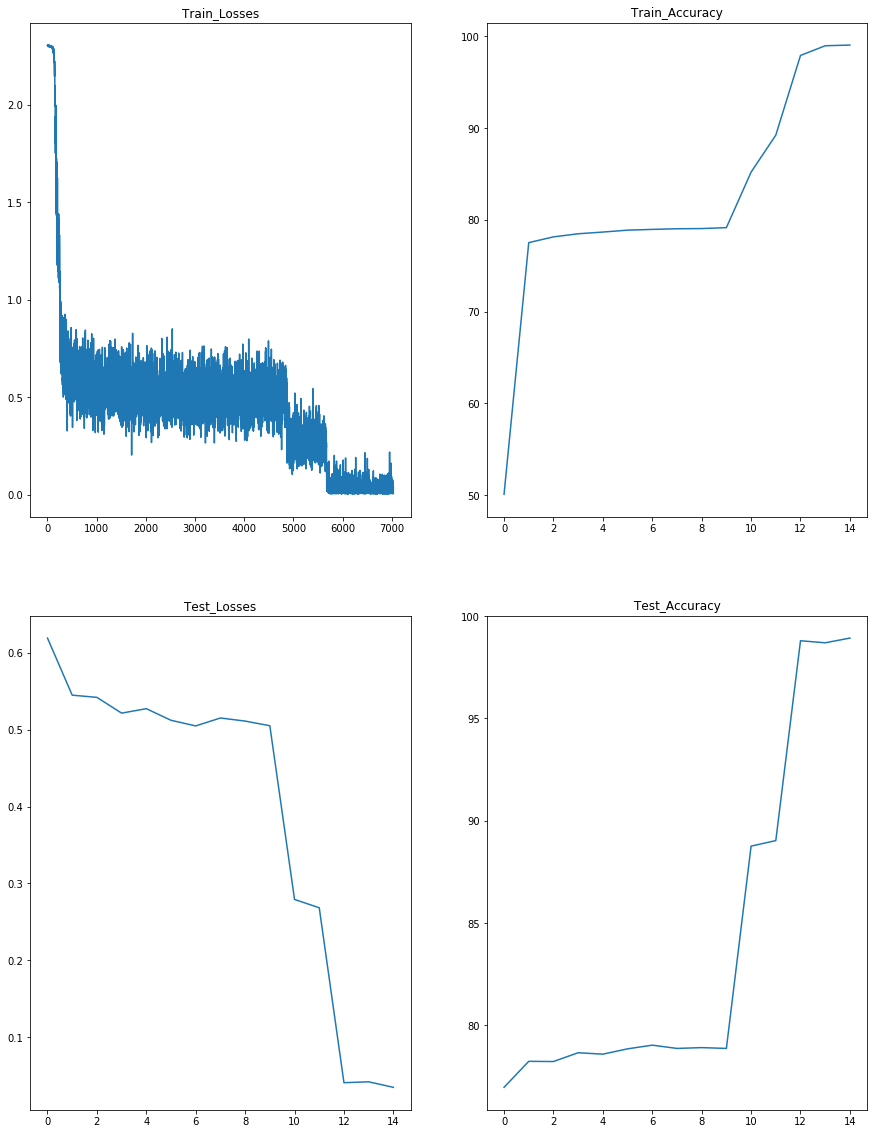

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(2,2,figsize=(15,20))
ax[0,0].plot(train_losses)
ax[0,0].set_title('Train_Losses')
ax[0,1].plot(train_accuracy)
ax[0,1].set_title('Train_Accuracy')

ax[1,0].plot(test_losses)
ax[1,0].set_title('Test_Losses')
ax[1,1].plot(test_accuracy)
ax[1,1].set_title('Test_Accuracy')